## Red Wine Quality

#### Context
The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult the reference [Cortez et al., 2009]. Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are much more normal wines than excellent or poor ones).

#### Content
Input variables (based on physicochemical tests):

1. fixed acidity

2. volatile acidity

3. citric acid

4. residual sugar

5. chlorides

6. free sulfur dioxide

7. total sulfur dioxide

8. density

9. pH

10. sulphates

11. alcohol

Output variable (based on sensory data):

12. quality (score between 0 and 10)

#### Tips
What might be an interesting thing to do, is aside from using regression modelling, is to set an arbitrary cutoff for your dependent variable (wine quality) at e.g. 7 or higher getting classified as 'good/1' and the remainder as 'not good/0'.
This allows you to practice with hyper parameter tuning on e.g. decision tree algorithms looking at the ROC curve and the AUC value.
Without doing any kind of feature engineering or overfitting you should be able to get an AUC of .88 (without even using random forest algorithm)

1. File Reader (for csv) to linear correlation node and to interactive histogram for basic EDA.

2. File Reader to 'Rule Engine Node' to turn the 10 point scale to dichtome variable (good wine and rest), the code to put in the rule engine is something like this:

$quality$ > 6.5 => "good"
TRUE => "bad"

3. Rule Engine Node output to input of Column Filter node to filter out your original 10point feature (this prevent leaking)

4. Column Filter Node output to input of Partitioning Node (your standard train/tes split, e.g. 75%/25%, choose 'random' or 'stratified')

5. Partitioning Node train data split output to input of Train data split to input Decision Tree Learner node and

6. Partitioning Node test data split output to input Decision Tree predictor Node

7. Decision Tree learner Node output to input Decision Tree Node input

8. Decision Tree output to input ROC Node.. (here you can evaluate your model base on AUC value)

### Imports Library

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression, BayesianRidge, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score, roc_curve, auc
from sklearn.feature_selection import SelectKBest, chi2

## A. Regression Task

### Read Data CSV

In [2]:
df = pd.read_csv('../Datasets/winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Exploratory Data Analysis (EDA)

#### Show dimension data, info data & data types

In [3]:
df.shape

(1599, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

#### How many data in quality column

In [6]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

Quality of wine just from 3 - 8

#### Show describe data & correlation data

In [7]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [8]:
df.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


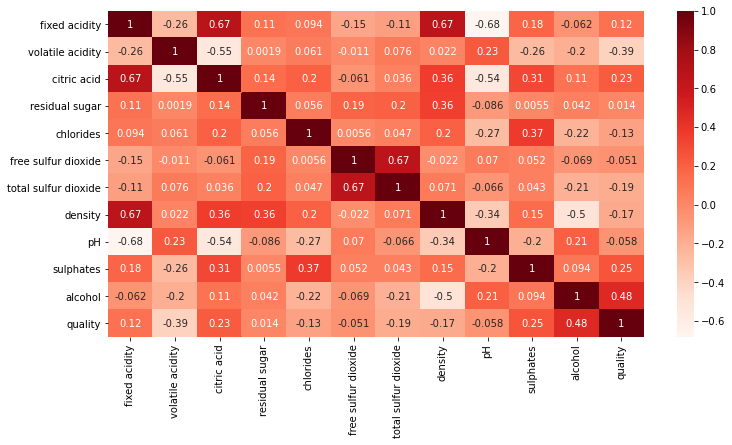

In [9]:
# plot correlation data
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), cmap='Reds', annot=True)
plt.show()

#### Check missing value, duplicate data, & outliers data

In [10]:
# check missing value
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Dataset doesn't have missing value

In [11]:
# check duplicate data
df[df.duplicated()]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
11,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
27,7.9,0.430,0.21,1.60,0.106,10.0,37.0,0.99660,3.17,0.91,9.5,5
40,7.3,0.450,0.36,5.90,0.074,12.0,87.0,0.99780,3.33,0.83,10.5,5
65,7.2,0.725,0.05,4.65,0.086,4.0,11.0,0.99620,3.41,0.39,10.9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1563,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1564,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1567,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1581,6.2,0.560,0.09,1.70,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5


Because quality value maybe have data duplicated and quality column is dependent variable, we don't remove it

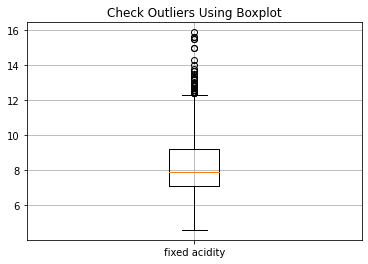

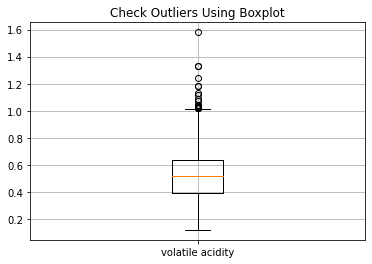

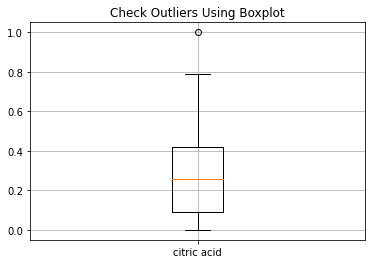

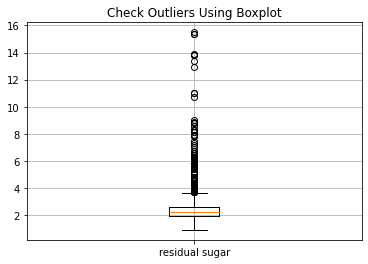

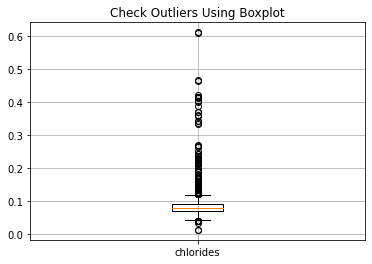

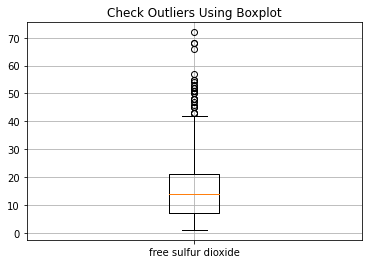

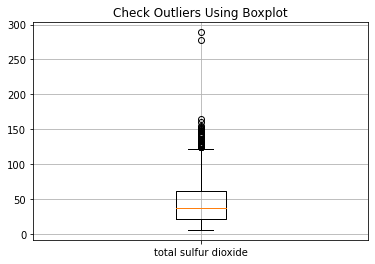

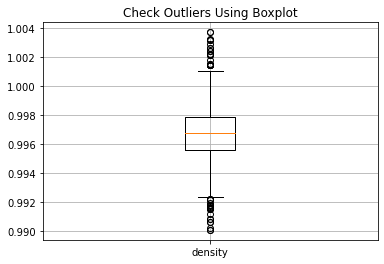

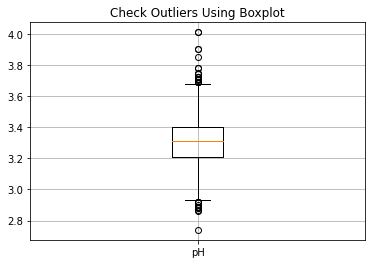

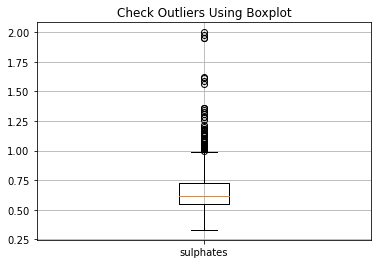

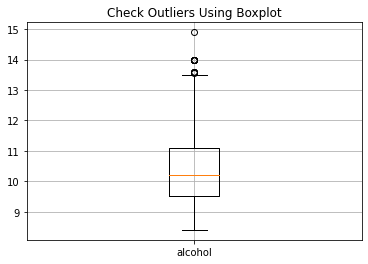

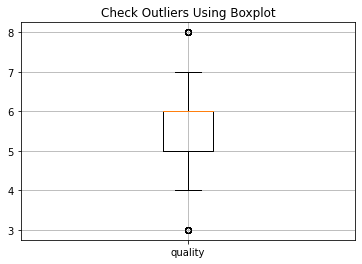

In [12]:
# using boxplot
for box in df.columns:
    plt.boxplot(df[box], labels=[box])
    plt.title('Check Outliers Using Boxplot')
    plt.grid()
    plt.show()

In [13]:
# check outliers data
# using IQR & boxplot or scatterplot

import numpy as np

for x in df.columns:
    Q3,Q1 = np.percentile(df.loc[:,x],[75,25])
    IQR = Q3 - Q1
 
    max = Q3 + (1.5 * IQR)
    min = Q1 - (1.5 * IQR)
 
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan

# Q1 = df.quantile(0.25)
# Q3 = df.quantile(0.75)
# IQR = Q3 - Q1
# # IQR
# low = Q1 - 1.5 * IQR
# high = Q3 + 1.5 * IQR
# # df2 = df[(df > low) & (df < high)]
# df2 = df[~((df < low) | (df > high)).any(axis=1)]

In [14]:
print(df.isnull().sum())
print(f' Jumlah data NaN: {df.isnull().sum().sum()}')

fixed acidity            49
volatile acidity         19
citric acid               1
residual sugar          155
chlorides               112
free sulfur dioxide      30
total sulfur dioxide     55
density                  45
pH                       35
sulphates                59
alcohol                  13
quality                  28
dtype: int64
 Jumlah data NaN: 601


In [15]:
df.dropna(axis=0, inplace=True)

In [16]:
print(df.isnull().sum())
print(f' Jumlah data NaN: {df.isnull().sum().sum()}')

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
 Jumlah data NaN: 0


In [22]:
# Change data types column quality to int

df['quality'] = df['quality'].astype('int64')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


#### Analys & Visualizations

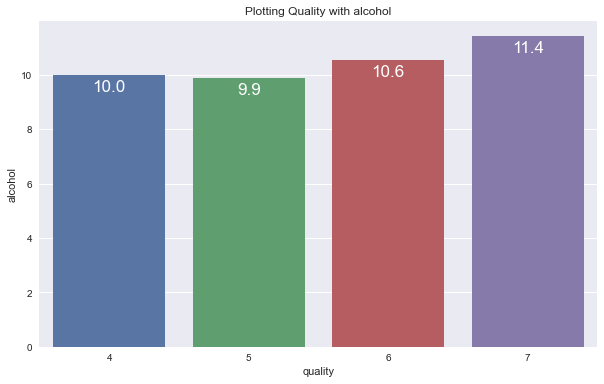

In [75]:
# Make function to plotting with anything input user about dataset df

def plotting(col_y):
    plt.style.use('seaborn')
    plt.subplots(figsize=(10,6))
    bar = sns.barplot(x='quality', y=col_y, data=df, ci=False)
    for i in bar.patches:
        bar.annotate(format(i.get_height(), '.1f'),
                     (i.get_x() + i.get_width() / 2., i.get_height()),
                     ha='center', va='center', color='white', size=17, xytext=(0,-12),
                     textcoords='offset points')
    plt.title(f'Plotting Quality with {col_y}')
    plt.show()

plotting('alcohol')

Quality wine has a high alcohol level so it has high quality is quality 7

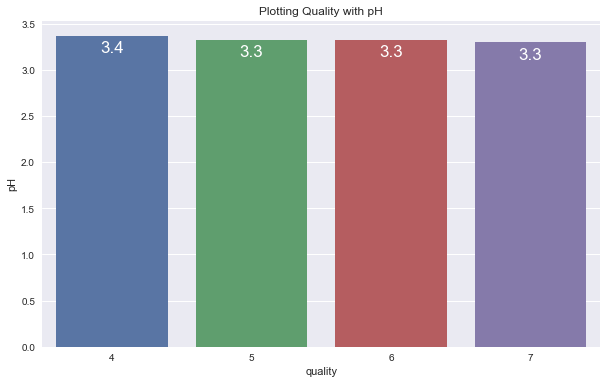

In [76]:
plotting('pH')

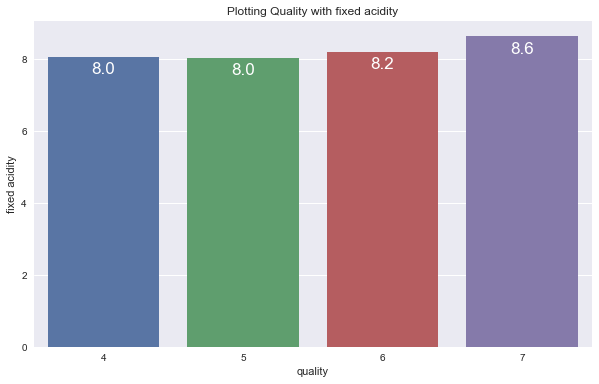

In [77]:
plotting('fixed acidity')

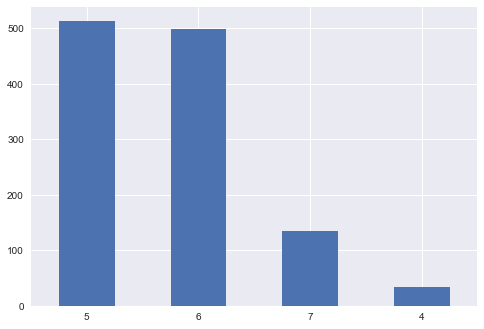

In [93]:
df.quality.value_counts().plot(kind='bar', rot=0);

The output variable likely have imbalanced data

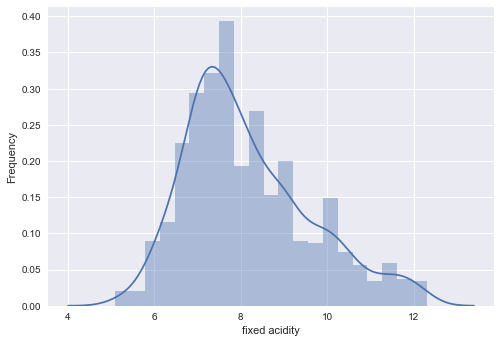

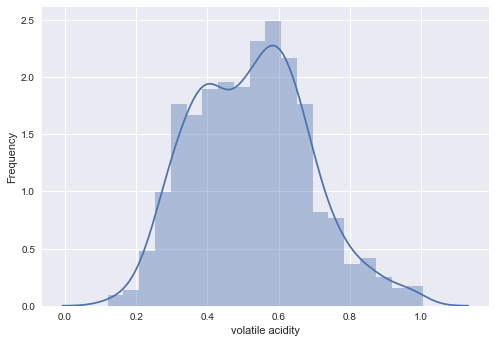

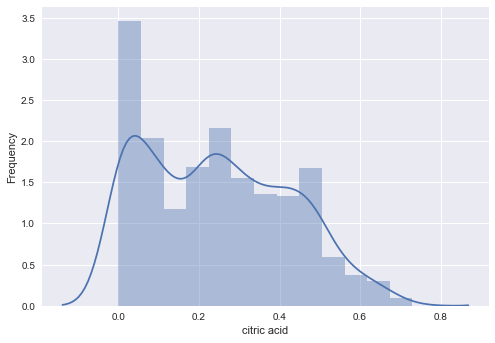

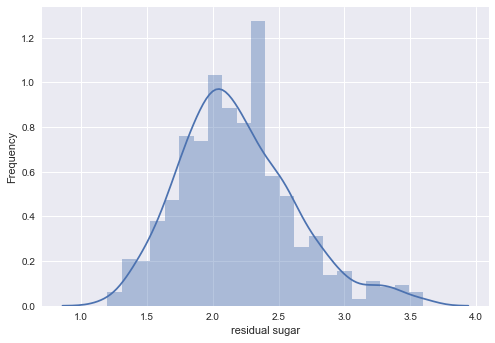

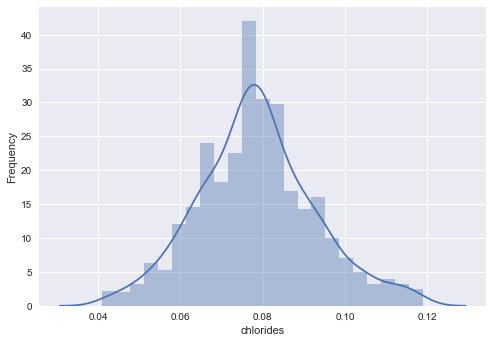

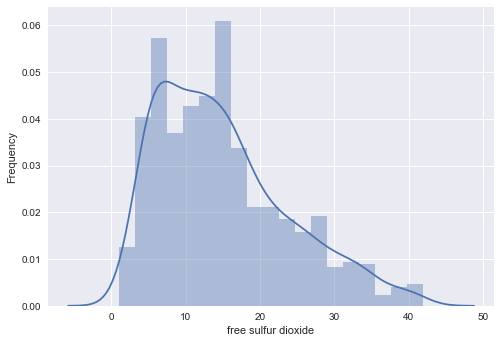

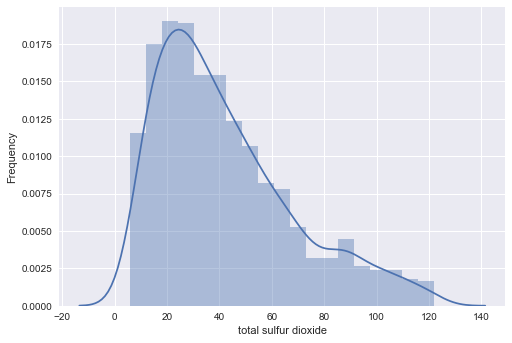

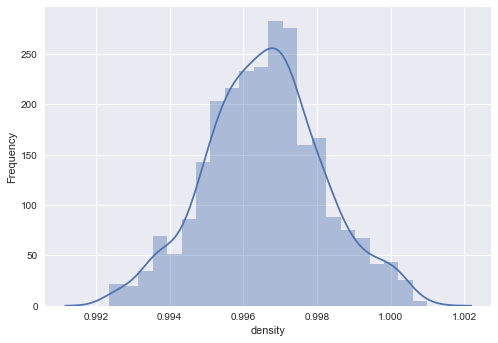

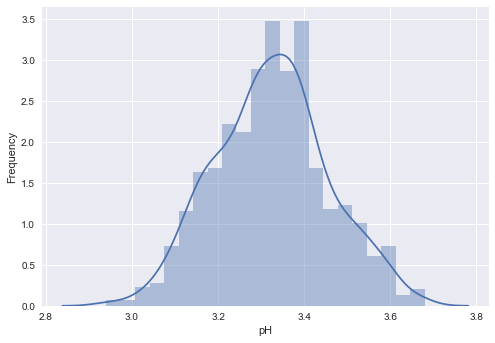

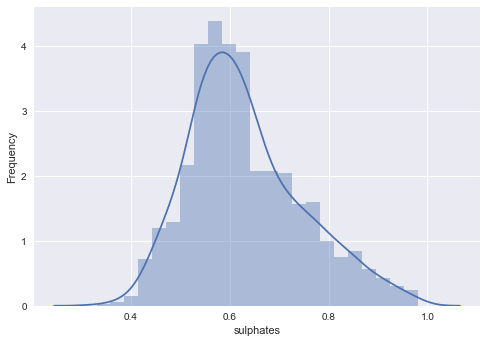

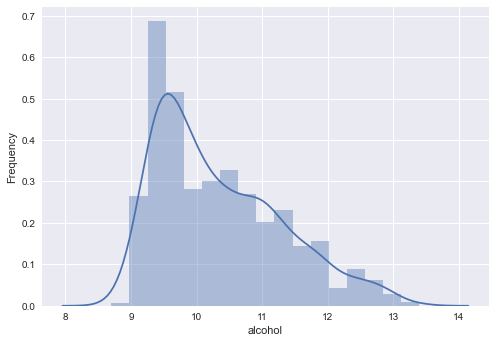

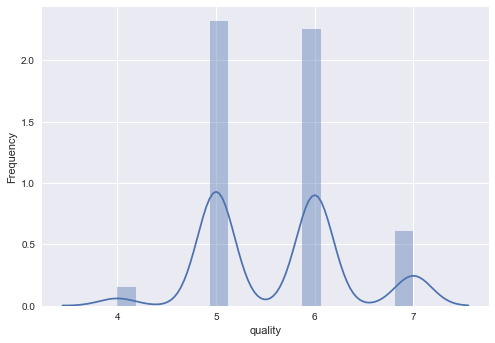

In [102]:
# Plotting data to see distribution for each column
def histPlot(col):
    sns.distplot(df[col])
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

for cols in df.columns:
    histPlot(cols)

### Feature Selection & Split Training Testing Data